<a href="https://colab.research.google.com/github/VincentStimper/normalizing-flows/blob/master/example/real_nvp_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Real NVP model

In [1]:
!pip install git+https://github.com/telegraphroad/NNF.git

  Cloning https://github.com/telegraphroad/NNF.git to /tmp/pip-req-build-7t6ikqsw
  Running command git clone --filter=blob:none --quiet https://github.com/telegraphroad/NNF.git /tmp/pip-req-build-7t6ikqsw
  Resolved https://github.com/telegraphroad/NNF.git to commit b3c496f5d46ed3a808f9b12430223f1a46ba3814
  Preparing metadata (setup.py) ... done

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [2]:
!which python

/home/samiri/anaconda3/envs/flows/bin/python


In [3]:
# Import required packages
import torch
import numpy as np
import normflows as nf

from sklearn.datasets import make_moons

from matplotlib import pyplot as plt

from tqdm import tqdm

In [4]:
# Set up model

# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(2)
base = nf.distributions.base.GaussianMixture(n_modes = 25, dim = 2, trainable=True)

# Define list of flows
num_layers = 32
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 64, 64, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))
    
# Construct flow model
model = nf.NormalizingFlow(base, flows)
bestmodel = nf.NormalizingFlow(base, flows)

In [5]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

In [6]:
# # Plot target distribution
# x_np, _ = make_moons(2 ** 20, noise=0.1)
# plt.figure(figsize=(15, 15))
# plt.hist2d(x_np[:, 0], x_np[:, 1], bins=200, range=[[-1.5, 2.5], [-2, 2]])
# plt.show()

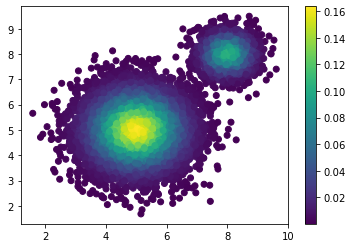

In [7]:
# # Plot initial flow distribution
# grid_size = 200
# xx, yy = torch.meshgrid(torch.linspace(-1.5, 2.5, grid_size), torch.linspace(-2, 2, grid_size))
# zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
# zz = zz.to(device)

# model.eval()
# log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
# model.train()
# prob = torch.exp(log_prob)
# prob[torch.isnan(prob)] = 0

# plt.figure(figsize=(15, 15))
# plt.pcolormesh(xx, yy, prob.data.numpy())
# plt.gca().set_aspect('equal', 'box')
# plt.show()
import torch.distributions as D
mix = D.Categorical(torch.tensor([1.,.2]))
m = 5.
m2 = 8.
v1 = .9
v2 = .9
v3 = .5
v4 = .5
comp = D.Independent(D.Normal(
             torch.tensor([[m,m],[m2,m2]]), torch.tensor([[v1,v2],[v3,v4]])), 1)
gmm = D.MixtureSameFamily(mix, comp)

smpl = gmm.sample([10000])
colors = gmm.log_prob(smpl).exp()
smpl = smpl.detach().cpu().numpy()
colors = colors.detach().cpu().numpy()
plt.scatter(smpl[:,0],smpl[:,1],c=colors)
plt.colorbar()

100%|████████████████████████████████████████████████████████████| 4000/4000 [03:22<00:00, 19.79it/s]


<Figure size 432x288 with 0 Axes>

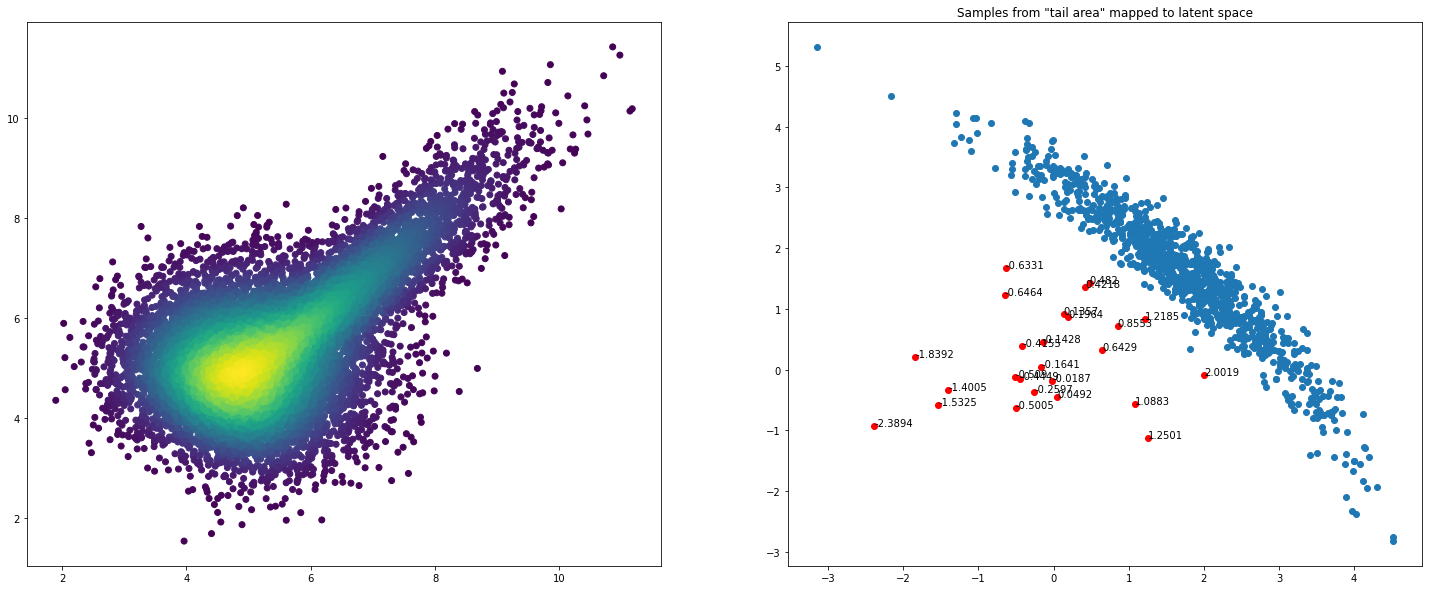

<Figure size 432x288 with 0 Axes>

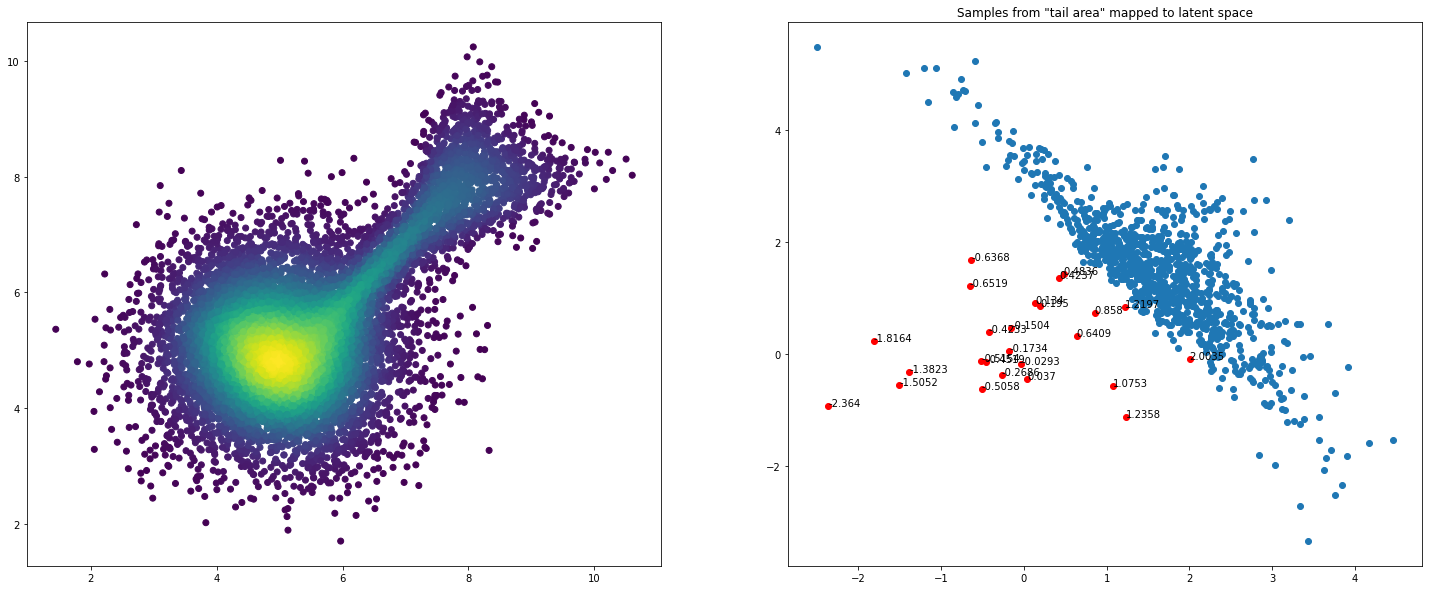

<Figure size 432x288 with 0 Axes>

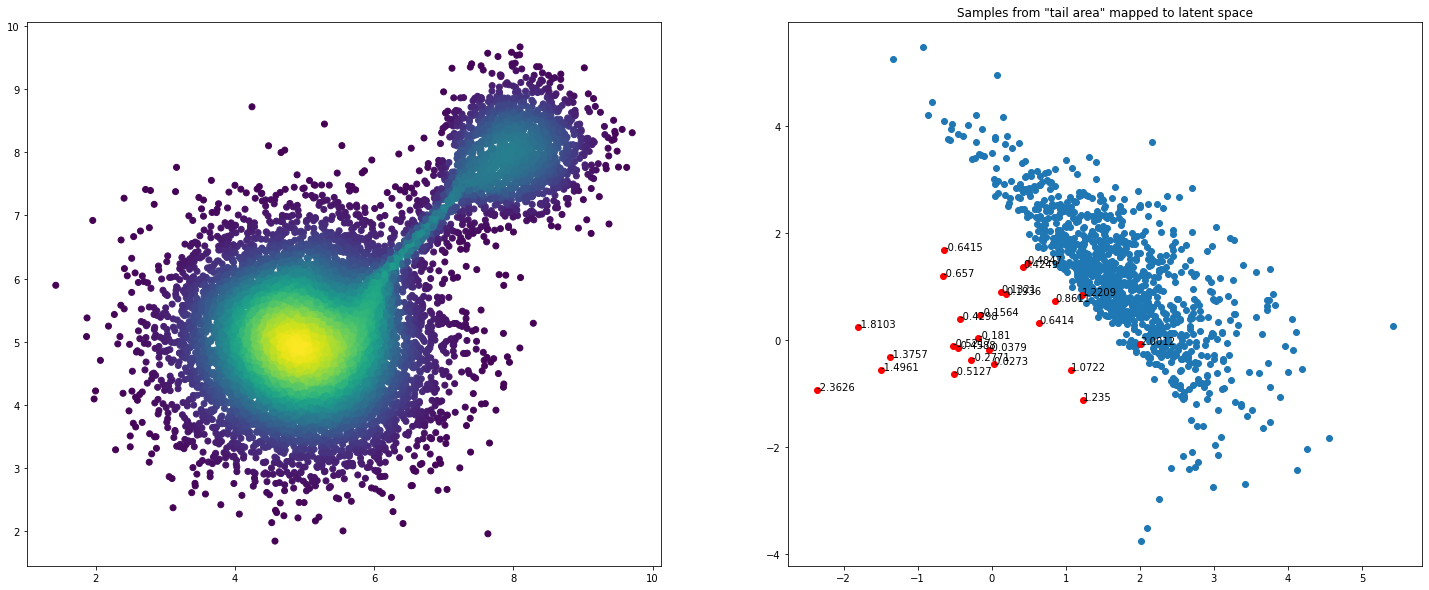

<Figure size 432x288 with 0 Axes>

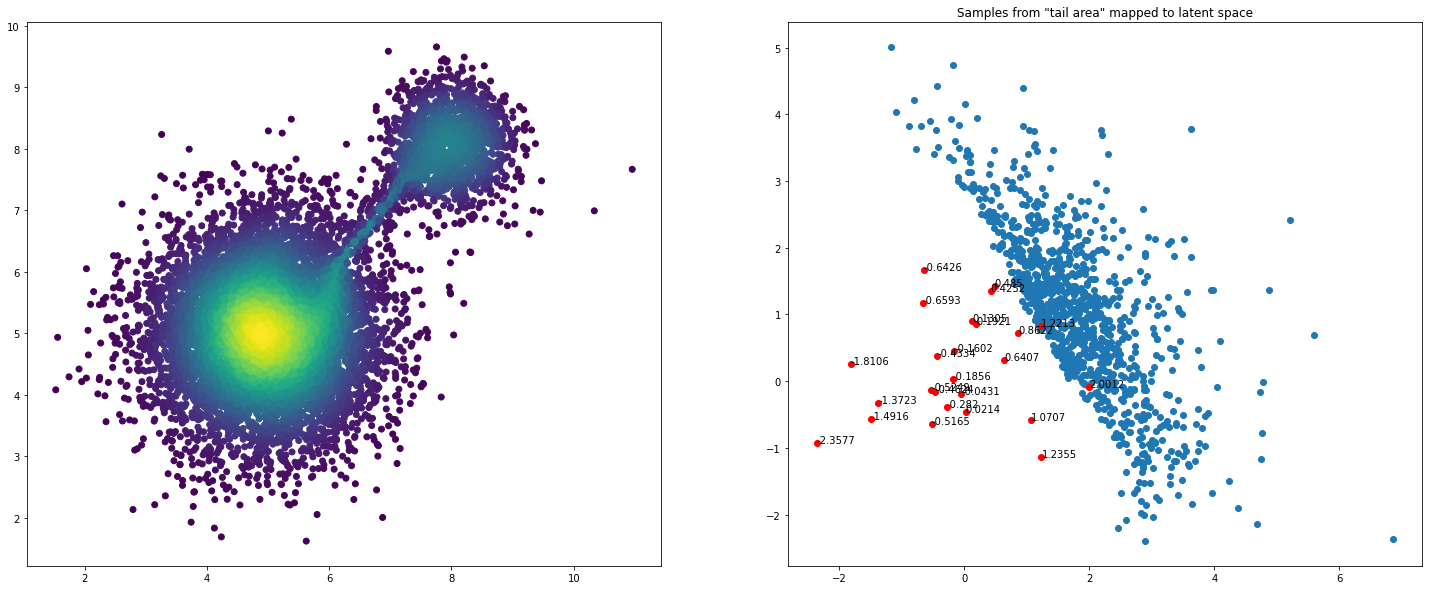

<Figure size 432x288 with 0 Axes>

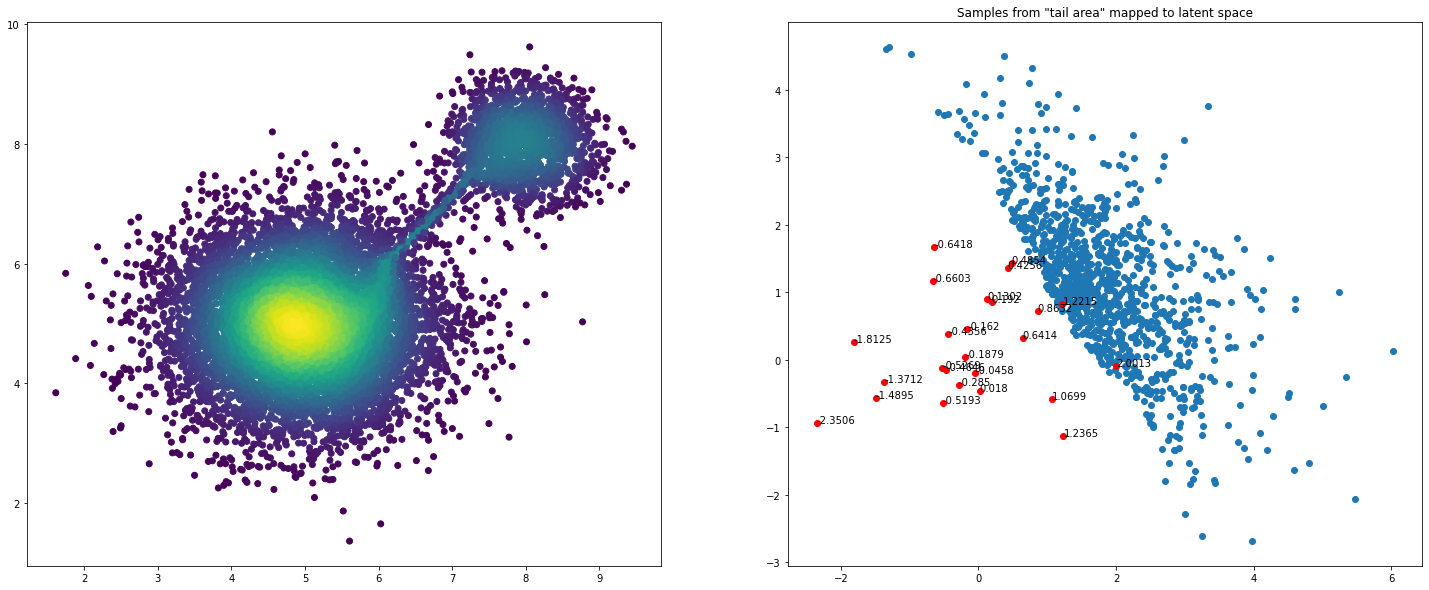

<Figure size 432x288 with 0 Axes>

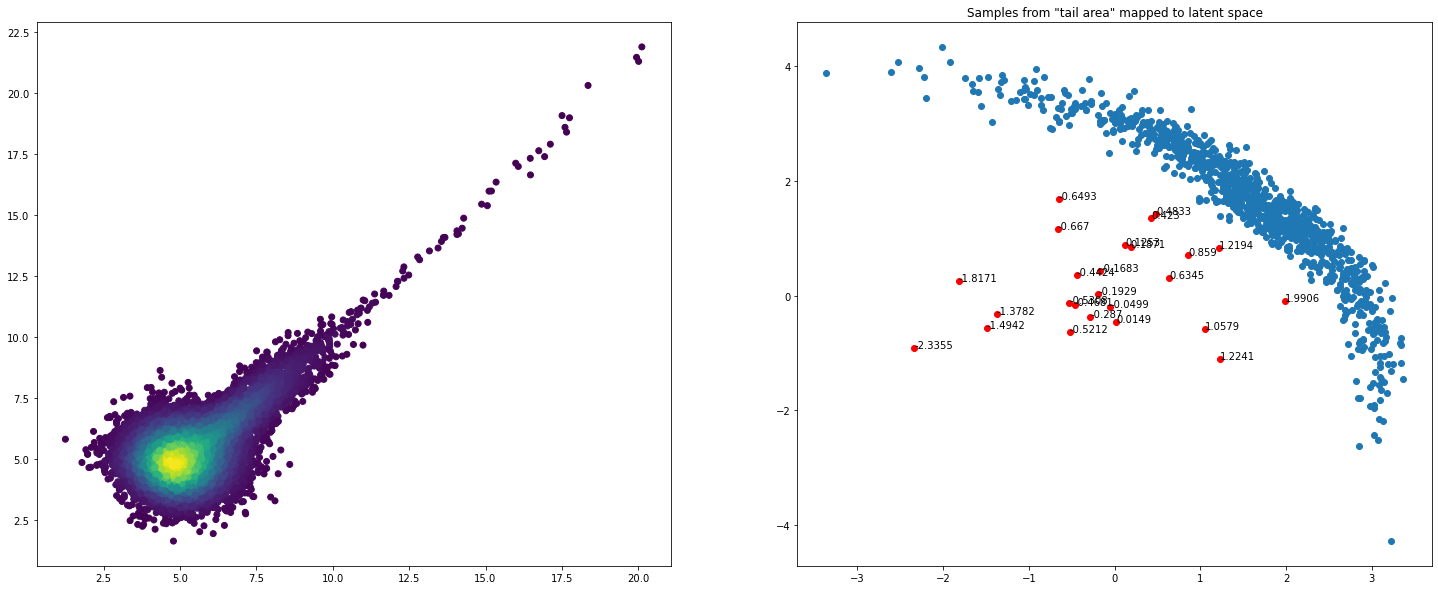

<Figure size 432x288 with 0 Axes>

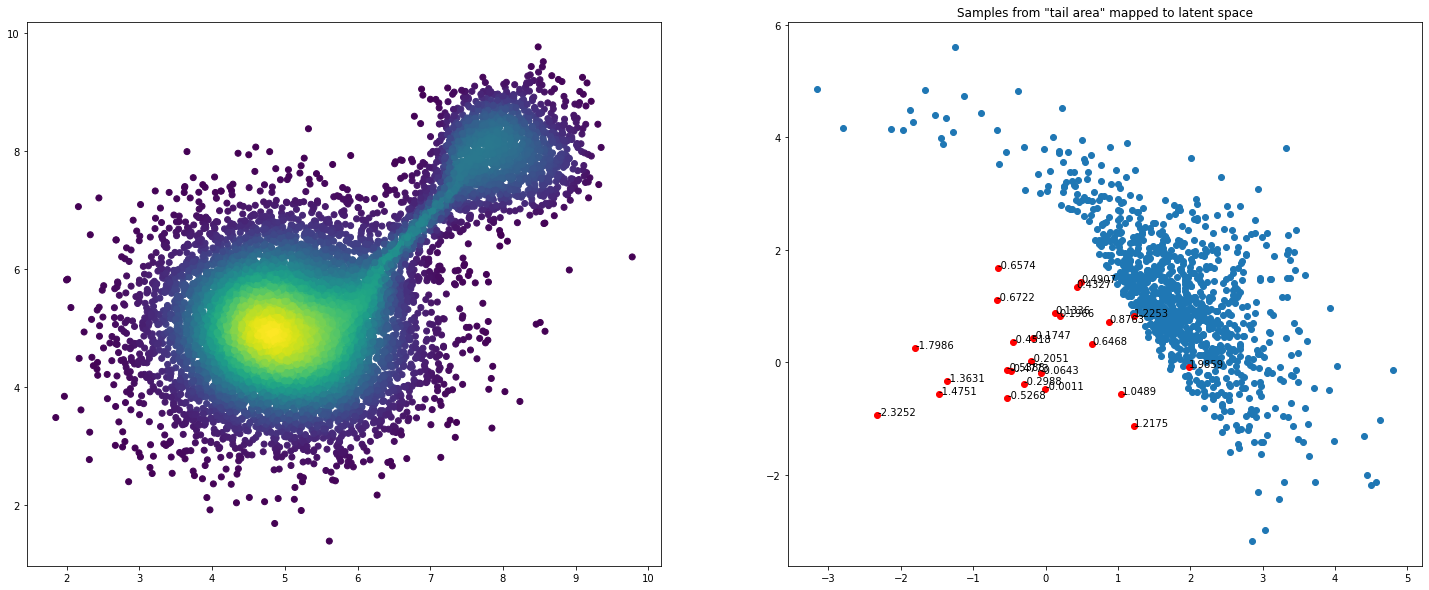

<Figure size 432x288 with 0 Axes>

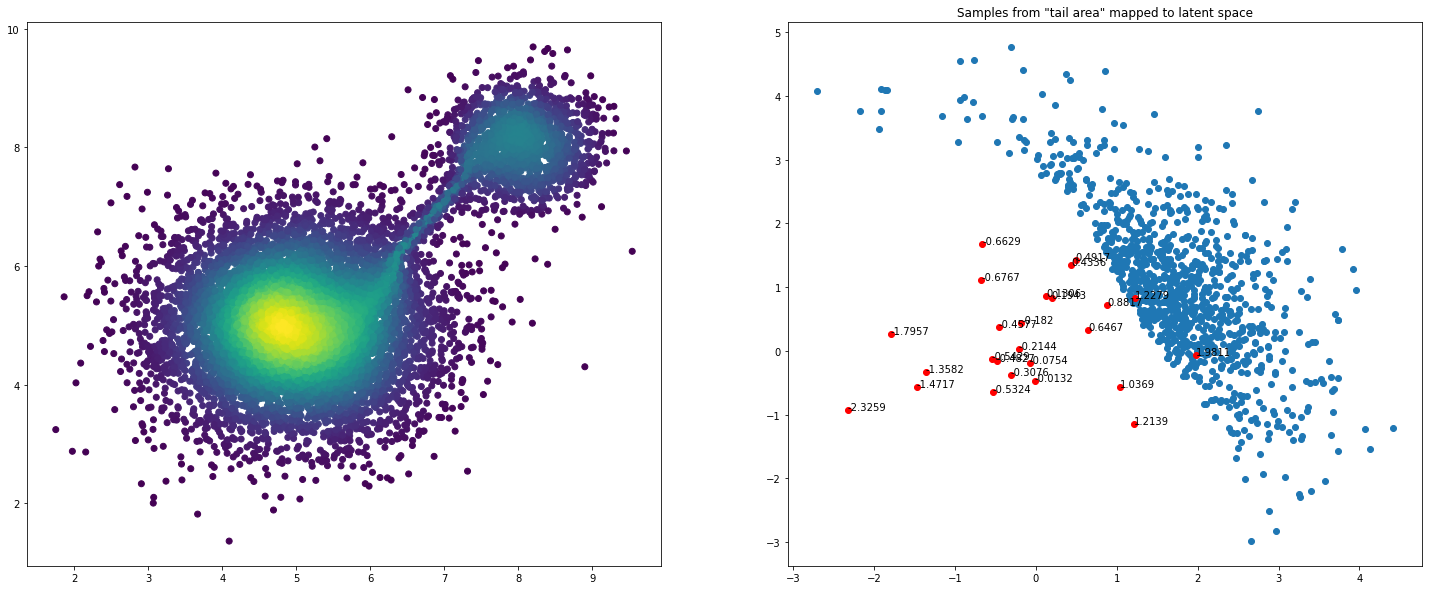

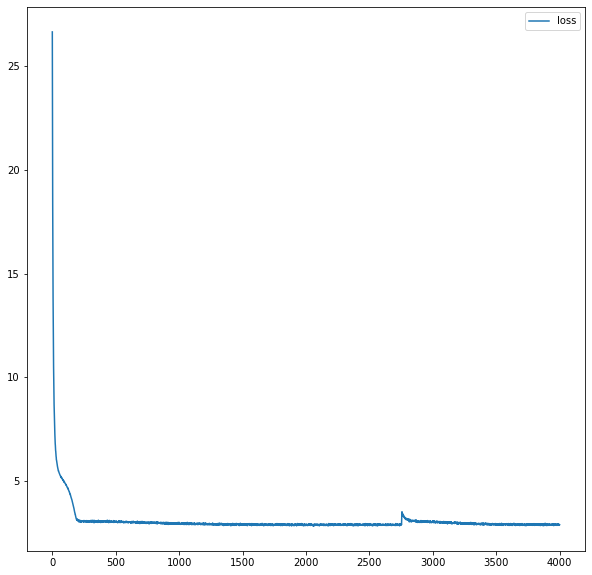

In [8]:
# Train model
max_iter = 4000
num_samples = 2 ** 11
show_iter = 500


loss_hist = np.array([])
bestloss = 9999999999999999999999999.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
checkpoints = []
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    x_np = gmm.sample([2048]).detach().cpu().numpy()
    x = torch.tensor(x_np).float().to(device)
    
    # Compute loss
    loss = model.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    if loss.detach().cpu().item() < bestloss:
        bestmodel.state_dict = model.state_dict
        bestloss = loss.detach().cpu().item()
    # Plot learned posterior
    if (it + 1) % show_iter == 0:
        checkpoints.append(model.state_dict)
        model.eval()

        # plt.figure(figsize=(15, 15)) 
        # plt.pcolormesh(xx, yy, prob.data.numpy())
        # plt.gca().set_aspect('equal', 'box')
        # plt.show()
        plt.figure()
        fig, ax = plt.subplots(1,2,figsize=[25,10])
        a = model.sample(10000)[0].detach().cpu().numpy()
        colors = model.log_prob(torch.tensor(a).cuda()).exp().detach().cpu().numpy()  

        ax[0].scatter(a[:,0],a[:,1],c=colors)
        
        

        m2 = D.Normal(loc=torch.tensor([8.,8.]),scale=torch.tensor([0.5,0.5]))
        smpl = m2.sample([1000]).cuda()

        z,l = bestmodel.forward_kld(smpl,extended=True)
        z = z.cpu().detach().numpy()
        
        ax[1].scatter(z[:,0],z[:,1])
        means = model.q0.loc.squeeze().cpu().detach().numpy()
        covs = model.q0.log_scale.exp().squeeze().cpu().detach().numpy()


        ax[1].scatter(means[:,0],means[:,1],color='red')
        ax[1].set_title('Samples from "tail area" mapped to latent space')
        for i, txt in enumerate(means[:,0]):
            ax[1].annotate(txt.round(decimals=4), (means[i,0], means[i,1]))
        

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

filament [this paper](https://proceedings.mlr.press/v151/stimper22a).

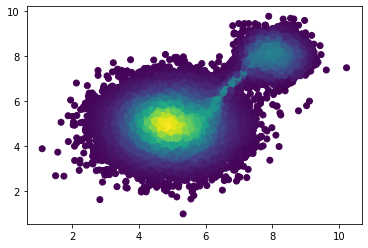

In [9]:
a = bestmodel.sample(20000)[0].detach().cpu().numpy()
colors = bestmodel.log_prob(torch.tensor(a).cuda()).exp().detach().cpu().numpy()  

plt.scatter(a[:,0],a[:,1],c=colors)
plt.show()


/tmp/ipykernel_11403/4288150271.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  smpl = torch.tensor(m2.sample([1000])).cuda()


array([[1.09983465, 1.07134183],
       [1.04953562, 0.99307903],
       [1.01566211, 0.98837514],
       [1.01261536, 0.93654972],
       [1.01361912, 0.9976902 ],
       [0.91356104, 0.98799709],
       [0.95038729, 1.04293864],
       [0.95299512, 0.98141918],
       [0.91618346, 0.99998528],
       [0.9451641 , 1.07243841],
       [1.05833057, 0.96591511],
       [1.01821776, 1.13601878],
       [0.9836086 , 0.95715652],
       [1.06914237, 1.02072046],
       [0.94681264, 0.92152438],
       [1.0083178 , 0.99948293],
       [1.01736253, 1.05220099],
       [0.98881764, 0.91679146],
       [0.98346088, 1.01086891],
       [0.95327061, 0.96161465],
       [0.91369834, 0.97856903],
       [0.91445546, 0.97730504],
       [0.99924062, 0.99753506],
       [1.05734838, 0.96506553],
       [0.9379895 , 0.98848115]])

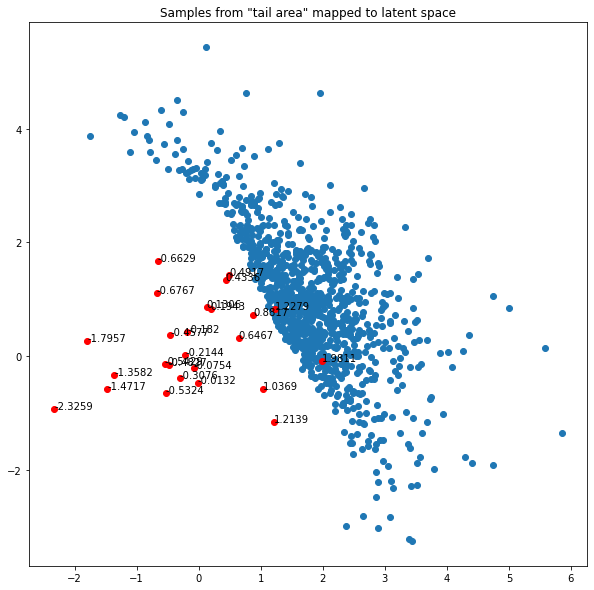

In [10]:
m2 = D.Normal(loc=torch.tensor([8.,8.]),scale=torch.tensor([0.5,0.5]))
smpl = torch.tensor(m2.sample([1000])).cuda()

z,l = bestmodel.forward_kld(smpl,extended=True)
z = z.cpu().detach().numpy()
fig, ax = plt.subplots(figsize=[10,10])
ax.scatter(z[:,0],z[:,1])
means = model.q0.loc.squeeze().cpu().detach().numpy()
covs = model.q0.log_scale.exp().squeeze().cpu().detach().numpy()


ax.scatter(means[:,0],means[:,1],color='red')
ax.set_title('Samples from "tail area" mapped to latent space')
for i, txt in enumerate(means[:,0]):
    ax.annotate(txt.round(decimals=4), (means[i,0], means[i,1]))
means
covs

/tmp/ipykernel_11403/1118369840.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  smpl = torch.tensor(m2.sample([2**11])).float().cuda()
/tmp/ipykernel_11403/1118369840.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


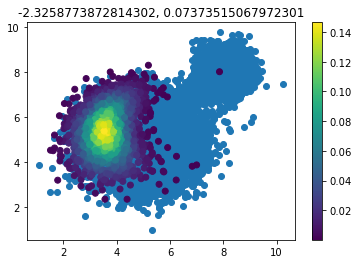

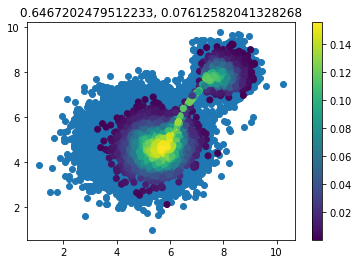

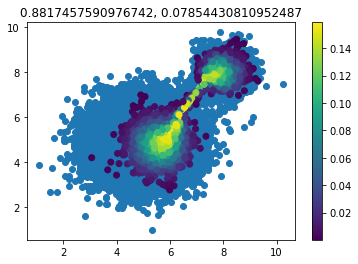

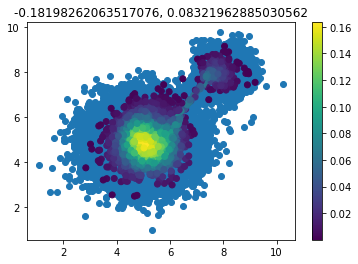

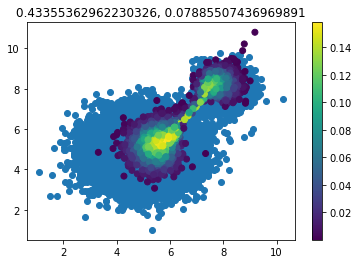

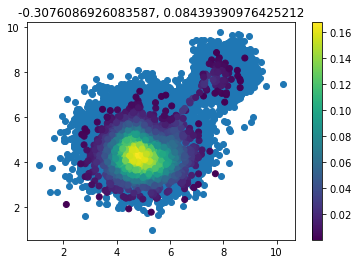

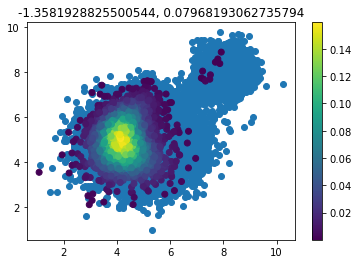

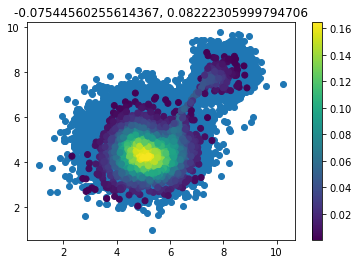

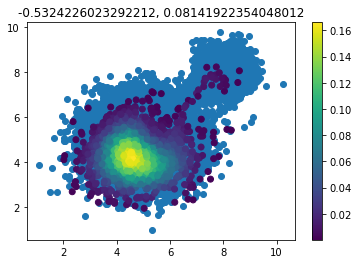

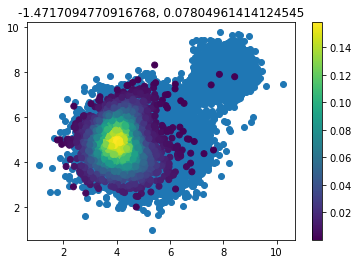

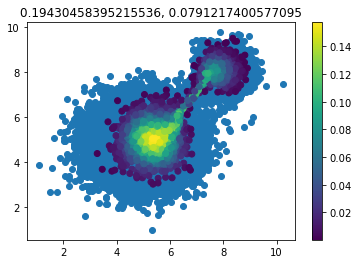

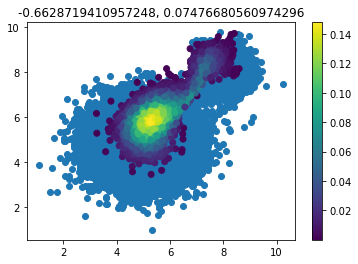

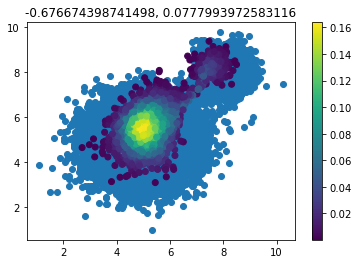

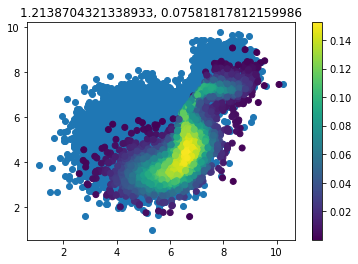

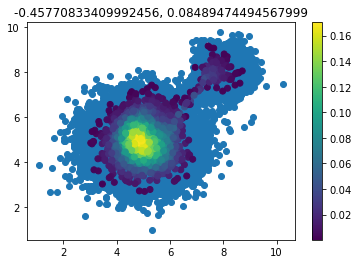

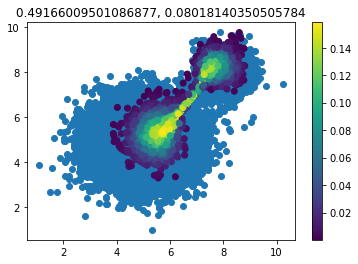

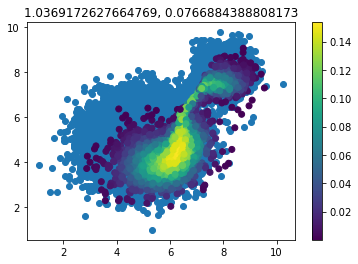

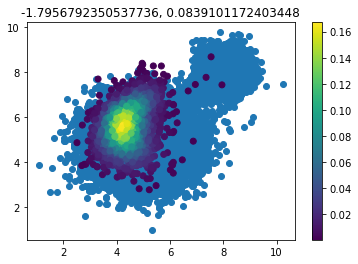

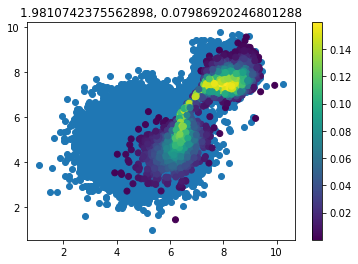

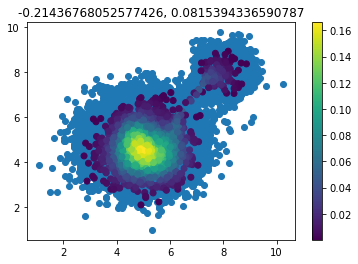

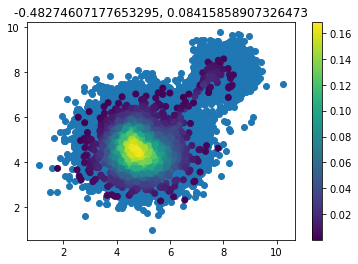

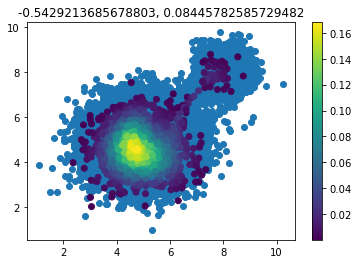

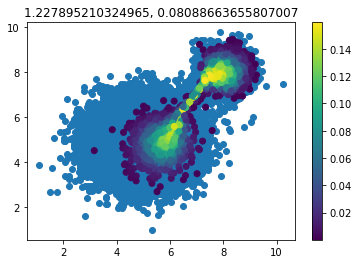

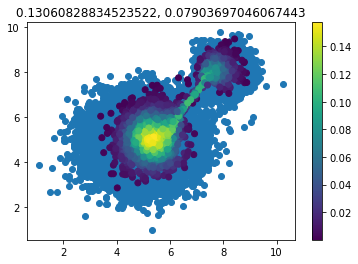

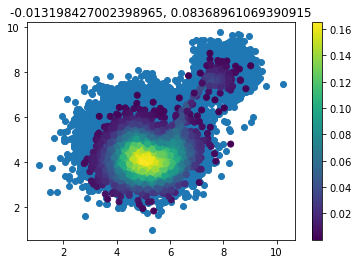

In [11]:
for ctr in range(len(means)):
    plt.figure()
    m2 = D.MultivariateNormal(torch.tensor([means[ctr , 0],means[ctr , 1]]),torch.tensor([[covs[ctr , 0] ,0],[0, covs[ctr , 1]]]))
    #m2 = D.Normal(torch.tensor([means[ctr , 0],means[ctr , 1]]),torch.tensor([covs[ctr , 0] , covs[ctr , 1]]))
    plt.scatter(a[:,0],a[:,1])

    smpl = torch.tensor(m2.sample([2**11])).float().cuda()
    lp = m2.log_prob(smpl.cpu()).cuda()#.mean(axis=1)
    #print(lp.shape)
    #bestmodel.q0 = m2
    z= model.backward(1000,z=smpl,log_q_=lp).cpu().detach().numpy()
    #z= model.backward(1000).cpu().detach().numpy()
    plt.scatter(z[:,0],z[:,1],c=lp.exp().cpu().detach().numpy())
    plt.title(str(means[ctr,0])+', '+str(lp.exp().mean().item()))
    plt.colorbar()

